In [1]:
import numpy as np
import torch
from torchvision.datasets import Cityscapes
import os
from glob import glob
import torch.nn.functional as F
from tqdm import tqdm
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import cv2
from PIL import Image
import imageio
from einops import rearrange
from torchvision import transforms
from torchvision.io import read_image
import torchvision
from transformers import CLIPSegProcessor, CLIPSegForImageSegmentation
from labels import id2label, label2id, id2color
from Lane_Detection.lane_detection import LaneDetector
import matplotlib.image as mimg

/data3/sb56/CP_proj/myenv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
class ImageDataset(Dataset):
    def __init__(self, data_dir):
        self.data_dir = data_dir
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        self.image_list = os.listdir(data_dir)

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        img_path = os.path.join(self.data_dir, self.image_list[idx])
        image = Image.open(img_path).convert('RGB')
        rgb_image = image.copy()
        if self.transform:
            image = self.transform(image)
        return image, np.array(rgb_image)
from segment_proj import test, DRNSeg

In [3]:
# im_dir = 'datasets/cityscapes/cityscapes/leftImg8bit/test/berlin'
im_dir = 'datasets/llama_subset'
MODEL_PATH = "drn_d_22_cityscapes.pth"
phase = "test"

In [4]:
single_model = DRNSeg("drn_d_22", 19, pretrained_model=None,
                          pretrained=False)

single_model.load_state_dict(torch.load(MODEL_PATH))
model = torch.nn.DataParallel(single_model).cuda()

/data3/sb56/CP_proj/myenv/lib/python3.9/site-packages/torch/cuda/__init__.py:546: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [5]:
# Create normalization required for DRN
info = {"std": [0.1829540508368939, 0.18656561047509476, 0.18447508988480435], "mean": [0.29010095242892997, 0.32808144844279574, 0.28696394422942517]}
normalize = transforms.Normalize(mean=info['mean'], std=info['std'])

In [6]:
image_dataset = ImageDataset(data_dir=im_dir)
# Resize later. DRN was trained on the default size, so I imagine it'll work better
image_dataset.transform = transforms.Compose([transforms.ToTensor(), normalize])
image_loader = DataLoader(image_dataset, batch_size=1, shuffle=True)
image_loader = DataLoader(image_dataset, batch_size=1, shuffle=True)

In [7]:
# Outputs lists of PIL images
_, outputs, road_masks, inputs = test(image_loader, model, 19)

/data3/sb56/CP_proj/repo/final_project/segment_proj.py:259: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  image_var = Variable(image, requires_grad=False, volatile=True)
/data3/sb56/CP_proj/repo/final_project/segment_proj.py:113: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return self.softmax(y), x
[2023-05-07 17:07:27,093 segment_proj.py:283 test] Eval: [0/1]	Time 1.303 (1.303)	Data 0.023 (0.023)	


In [8]:
def image_list_to_tensor(imgs):
    """
    Converts list of PIL images to tensors
    """
    transform = transforms.ToTensor()
    tensor_list = [ transform(img) for img in imgs]

    # Concatenate the list of tensors along the first dimension to create a tensor of shape (num_images, channels, height, width)
    return torch.stack(tensor_list, dim=0)

In [11]:
def image_list_to_nparray(imgs):
    nparray = []
    for img in imgs:
        nparray.append(np.array(img, dtype=np.int32))
    return np.array(nparray)

In [16]:
road_masks = image_list_to_nparray(road_masks)
outputs = image_list_to_nparray(outputs)
inputs = image_list_to_nparray(inputs)

In [32]:
image_bgr = cv2.cvtColor(inputs[0].astype(np.uint8), cv2.COLOR_RGB2BGR)
resized_input = cv2.resize(image_bgr, (road_masks[0].shape[1], road_masks[0].shape[0]))
print(resized_input.shape)
resized_image_rgb = cv2.cvtColor(resized_input, cv2.COLOR_BGR2RGB)

ld = LaneDetector(0.05, 0.09, 7, line_threshold=25, cropping_mask=np.array(road_masks[0], dtype=np.int32))
lane_img, lines_xy = ld.detect_lanes(resized_input)

(720, 1280, 3)
(720, 1280) (720, 1280)


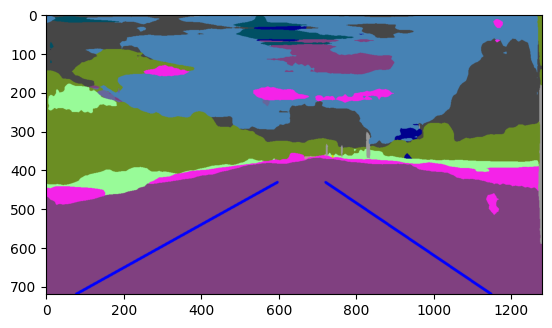

In [38]:
out_mask = outputs[0].copy()
cv2.line(out_mask, (lines_xy[0][0], lines_xy[0][1]), (lines_xy[0][2], lines_xy[0][3]), (0, 0, 255), 5)
cv2.line(out_mask, (lines_xy[1][0], lines_xy[1][1]), (lines_xy[1][2], lines_xy[1][3]), (0, 0, 255), 5)
plt.imshow(out_mask)

## Define Labels
Use KMeans to figure out colors

## Define Dataset

In [32]:
train_label_path = ('cityscapes/gtFine/gtFine/train/aachen')
train_path = ('cityscapes/leftImg8bit/leftImg8bit/train/aachen')
valid_path = glob('cityscapes/gtFine/gtFine/val/*')
test_path = glob('cityscapes/gtFine/gtFine/val/*')

In [33]:
class CropBottomThird(object):
    def __init__(self):
        pass

    def __call__(self, image):
        height, width = image.size()[-2:]
        new_height = height# //2
        print(new_height)
        return transforms.functional.crop(image, 0, 0, new_height, width)

In [34]:
RGB = torchvision.io.ImageReadMode.RGB
class CityscapeDataset(Dataset):
    
    def __init__(self, image_dir, label_dir):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_fns = os.listdir(image_dir)
        
    def __len__(self):
        return len(self.image_fns)
    
    def __getitem__(self, index):
        image_fn = self.image_fns[index]
        label_fn = image_fn.replace('leftImg8bit', 'gtFine_color')
        
        image_fp = os.path.join(self.image_dir, image_fn)
        label_fp = os.path.join(self.label_dir, label_fn)
        print(image_fp, label_fp)
        original = self.transform(read_image(image_fp) /255.0)
        original = transforms.Resize((1024, 1024))(original)
        
        label = self.transform(read_image(label_fp, RGB) / 255.0)
        
        
        # cityscape = self.transform(cityscape)

        return original, label
    
    def transform(self, image):
        transform_ops = transforms.Compose([
            # transforms.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))
            CropBottomThird(),
        ])
        return transform_ops(image)

In [35]:
train = CityscapeDataset(train_path, train_label_path)

FileNotFoundError: [Errno 2] No such file or directory: 'cityscapes/leftImg8bit/leftImg8bit/train/aachen'

In [ ]:
len(train)

In [ ]:
cityscape, label_class = train[4]
print(cityscape.shape, label_class.shape)

In [ ]:
def tensor_to_im(im):
    return rearrange(im, 'C H W -> H W C').numpy()

In [36]:
def display_im(image):
    image = tensor_to_im(image)
    plt.imshow(image)
    plt.show()

In [37]:
display_im(cityscape)
display_im(label_class)

NameError: name 'cityscape' is not defined

## Define Color Utils

In [ ]:
# These are the colors for various objects in the segmented image
# found at https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py
colors = {
 "traffic light": (250,170, 30),
    "traffic sign": (220,220, 0)
}

In [ ]:
def display_color(color):
    # Create a 24x24 array of the color
    arr = np.zeros((24, 24, 3), dtype=int)
    arr[:, :] = color
    
    # Display the image using pyplot
    plt.imshow(arr)
    plt.show()

In [ ]:
def get_object_mask(object_name, images):
    """
    Takes (batch_size, channels, height, width) image tensor
    """
    color = colors[object_name]
    images = rearrange(images, 'N C H W -> N H W C')
    mask = torch.all(images[:,:,:]==color)
    return rearrange(mask, 'N H W C -> N C H W')

In [ ]:
display_color(colors['traffic light'])
display_color(colors['traffic sign'])

## Import Models

In [ ]:
processor = CLIPSegProcessor.from_pretrained("CIDAS/clipseg-rd64-refined")
model = CLIPSegForImageSegmentation.from_pretrained("CIDAS/clipseg-rd64-refined")

In [ ]:
image = cityscape

In [ ]:
prompts = ["traffic light", "car"]

In [ ]:
inputs = processor(text=prompts, images=[image] * len(prompts), padding="max_length", return_tensors="pt")

In [ ]:
with torch.no_grad():
  outputs = model(**inputs)
preds = outputs.logits.unsqueeze(1)

In [ ]:
_, ax = plt.subplots(1, len(prompts) + 1, figsize=(3*(len(prompts) + 1), 4))
[a.axis('off') for a in ax.flatten()]
ax[0].imshow(tensor_to_im(image))
[ax[i+1].imshow((F.softmax(preds[i][0])> 0.01) * 255) for i in range(len(prompts))];
[ax[i+1].text(0, -15, prompt) for i, prompt in enumerate(prompts)];

In [ ]:
np.sum((preds[1][0] > 0.4).numpy())

In [ ]:
torch.sum(F.softmax(preds[1][0])>0.01)

## Define the Model

In [ ]:
from transformers import SegformerForSemanticSegmentation, SegformerFeatureExtractor

In [ ]:
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")
model = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b0-finetuned-cityscapes-1024-1024")

In [ ]:
image = cityscape
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)
logits = outputs.logits

In [ ]:
# First, rescale logits to original image size
upsampled_logits = F.interpolate(logits,
                size=(1024,1024), # (height, width)
                mode='bilinear',
                align_corners=False)

In [ ]:
upsampled_logits.argmax(dim=1).shape

In [ ]:
# Second, apply argmax on the class dimension
seg = upsampled_logits.argmax(dim=1).squeeze(0)
color_seg = np.zeros((seg.shape[0], seg.shape[1], 3), dtype=np.uint8) # height, width, 3
for label_id, color in id2color.items():
    color_seg[seg == label_id, :] = color
# Convert to BGR
color_seg = color_seg[..., ::-1]

# Show image + mask
img = np.array(rearrange(image, 'C H W -> H W C')) * 0.5 + color_seg * 0.5
img = img.astype(np.uint8)

plt.figure(figsize=(15, 10))
plt.imshow(img)
plt.show()
seg